In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/ilaburcev/Documents/ml_for_business/data/support_data.csv').drop('Unnamed: 0', 1)
df.head()

/var/folders/x5/nk_prv9d701_y8xfmh051qdw0000gn/T/ipykernel_24910/231305267.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = pd.read_csv('/Users/ilaburcev/Documents/ml_for_business/data/support_data.csv').drop('Unnamed: 0', 1)


,Title,Resolution,class,category
0,Need Ethernet access,Please connect the LAN cable to the red port o...,41,1
1,Create new account and share the username and ...,"Go to URL : accountsetup.com, Enter personal d...",35,0
2,FW: Myspace Login Issue-- Ania,"Go to URL : password.reset.com, Enter you logi...",36,0
3,Login credetials are not working.,"Go to URL : password.reset.com, Enter you logi...",36,0
4,New Account is needed for a new joinee.,"Go to URL : accountsetup.com, Enter personal d...",35,0


In [3]:
df.category.value_counts()

0    125
1     25
Name: category, dtype: int64

In [4]:
# 1 - это проблемы с интернетом, 0 - проблемы другие. Тут видно , что происходит дисбаланс классов

В качестве поля для генерации признаков будем использовать Title. Сразу же будем работать с использованием sklearn pipline

In [5]:
# разбиение признаков на train test
X_train, X_test, y_train, y_test = train_test_split(df, df['category'], random_state=0)

In [6]:
X_train.head()

,Title,Resolution,class,category
61,Blocked account. Impossible to connect,Unlocked the account and new password is sent ...,47,0
92,My computer does not turn on?,Check that all the cables are securely plugge...,3,0
112,What is a computer virus?,A computer virus is a software program that h...,0,0
2,FW: Myspace Login Issue-- Ania,"Go to URL : password.reset.com, Enter you logi...",36,0
141,"I receive a ""no signal input"" message, what sh...",Verify that the monitor is properly connected...,27,0


In [7]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


pipeline = Pipeline([
    ('title_selector', FeatureSelector(column='Title')),
    ('title_tfdf', TfidfVectorizer(stop_words='english', max_features=1000)),
    ('clf', LogisticRegression())
],
verbose=True)

FeatureSelector - выбирает столбец Title и передает его значения на следующий шаг
TfdfVectorizer - векторизирует текст (поле Title)
LogisticRegression - наш бинарный классификатор, который обучается на результатах предыдущих шагов в разметке (их мы передадим уже на обучение)

Bow # мешок слов

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
docs =[
    'Wifi access required',
    'My computer does not connect to wifi',
    'My computer freezes',
    'What is a computer virus?'
]

In [10]:
cv = CountVectorizer(max_features=16, stop_words='english')

# считаем слова
word_ = cv.fit_transform(docs)

In [11]:
print(word_[0])

  (0, 7)	1
  (0, 0)	1
  (0, 5)	1


In [12]:
word_.shape

(4, 8)

In [13]:
vocab = list(cv.vocabulary_.keys())
vocab

['wifi',
 'access',
 'required',
 'computer',
 'does',
 'connect',
 'freezes',
 'virus']

In [14]:
print(cv.transform(['My Computer freezes']))

  (0, 1)	1
  (0, 4)	1


In [15]:
 pd.DataFrame.sparse.from_spmatrix(word_, columns=cv.get_feature_names_out())

,access,computer,connect,does,freezes,required,virus,wifi
0,1,0,0,0,0,1,0,1
1,0,1,1,1,0,0,0,1
2,0,1,0,0,1,0,0,0
3,0,1,0,0,0,0,1,0


TFiDF

In [16]:
tf0 = TfidfVectorizer(stop_words='english', max_features=16)
tf0.fit(docs)

TfidfVectorizer(max_features=16, stop_words='english')

In [17]:
x0 = tf0.transform(docs[:1])
print(docs[0])
print(x0)

Wifi access required
  (0, 7)	0.48693426407352264
  (0, 5)	0.6176143709756019
  (0, 0)	0.6176143709756019


In [18]:
# соберем значения
df_idf = pd.DataFrame(tf0.idf_, index=tf0.get_feature_names_out(), columns=['idf_weights'])

# сортировка по силе
df_idf.sort_values(by=['idf_weights'])

,idf_weights
computer,1.223144
wifi,1.510826
access,1.916291
connect,1.916291
does,1.916291
freezes,1.916291
required,1.916291
virus,1.916291


In [19]:
pd.DataFrame.sparse.from_spmatrix(tf0.transform(docs), columns=tf0.get_feature_names_out())

,access,computer,connect,does,freezes,required,virus,wifi
0,0.617614,0.000000,0.00000,0.00000,0.000000,0.617614,0.000000,0.486934
1,0.000000,0.366747,0.57458,0.57458,0.000000,0.000000,0.000000,0.453005
2,0.000000,0.538029,0.00000,0.00000,0.842926,0.000000,0.000000,0.000000
3,0.000000,0.538029,0.00000,0.00000,0.000000,0.000000,0.842926,0.000000


In [20]:
# вернемся к нашим данным

In [21]:
tf1 = TfidfVectorizer(stop_words='english', max_features=100)
tf1.fit(X_train['Title'])

x1 = tf1.transform(X_train['Title'].iloc[:1])
print(X_train['Title'].iloc[:1])
print(x1)

61    Blocked account. Impossible to connect
Name: Title, dtype: object
  (0, 17)	0.5610460677085695
  (0, 11)	0.6306430064818508
  (0, 1)	0.5362058450672498


In [22]:
feature_names = tf1.get_feature_names()
print(feature_names)

['access', 'account', 'addresses', 'allowed', 'ania', 'anymore', 'appears', 'attachments', 'battery', 'behaving', 'bin', 'blocked', 'blue', 'borders', 'come', 'computer', 'configure', 'connect', 'contraseña', 'create', 'credetials', 'damage', 'database', 'delete', 'determine', 'disk', 'display', 'distorted', 'does', 'drive', 'email', 'erase', 'erratically', 'expiry', 'file', 'fix', 'fw', 'hangs', 'hard', 'input', 'install', 'installation', 'internet', 'issue', 'jam', 'la', 'lan', 'laptop', 'login', 'lost', 'macbook', 'machine', 'mail', 'message', 'microsoft', 'middle', 'mode', 'monitor', 'mot', 'mouse', 'myspace', 'need', 'network', 'new', 'outlook', 'pages', 'paper', 'passe', 'password', 'postgres', 'printer', 'problem', 'program', 'protection', 'qa', 'receive', 'recover', 'recycle', 'replace', 'request', 'reset', 'safe', 'screen', 'send', 'share', 'signal', 'space', 'spaces', 'startup', 'strangely', 'turn', 'update', 'username', 'users', 'virus', 'wifi', 'windows', 'work', 'working',

/Users/ilaburcev/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
pd.DataFrame.sparse.from_spmatrix(tf1.transform(X_train['Title']), columns=tf1.get_feature_names_out())

,access,account,addresses,allowed,ania,anymore,appears,attachments,battery,behaving,...,turn,update,username,users,virus,wifi,windows,work,working,xwq090
0,0.0,0.536206,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.668301,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.792414,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.464046,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
108,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.598528,0.000000,0.0,0.000000,0.0,0.0,0.0
109,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.363257,0.0,0.353148,0.0,0.0,0.0
110,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


Резюмируем:
 Токенезация (перевод в токены, чаще всего это слова)
 Создаем словарь слов из токенов
 Векторизация

Назад к пайплайну

In [24]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля

pipeline = Pipeline([
    ('title_selector', FeatureSelector(column='Title')),
    ('title_tfidf', TfidfVectorizer(stop_words='english', max_features=100)),
    ('clf', LogisticRegression())
], verbose=True)

In [25]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

[Pipeline] .... (step 1 of 3) Processing title_selector, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing title_tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s


Pipeline(steps=[('title_selector', FeatureSelector(column='Title')),
                ('title_tfidf',
                 TfidfVectorizer(max_features=100, stop_words='english')),
                ('clf', LogisticRegression())],
         verbose=True)

In [26]:
pipeline.classes_

array([0, 1])

In [27]:
pipeline.named_steps

{'title_selector': FeatureSelector(column='Title'),
 'title_tfidf': TfidfVectorizer(max_features=100, stop_words='english'),
 'clf': LogisticRegression()}

In [28]:
pipeline['clf']

LogisticRegression()

In [29]:
pipeline[1]

TfidfVectorizer(max_features=100, stop_words='english')

In [30]:
pipeline[1].transform(X_test.Title)

<38x100 sparse matrix of type '<class 'numpy.float64'>'
	with 94 stored elements in Compressed Sparse Row format>

In [31]:
X_test.head()

,Title,Resolution,class,category
114,What to do when my computer crashes?,There are many reasons why a computer may jus...,21,0
62,Can a virus damage computer hardware?,No. Computer viruses are software code design...,16,0
33,How do I delete Internet cookies?,Microsoft Internet Explorer users can go to '...,15,0
107,The office does not work,Please check the Power cables are properly plu...,40,0
7,LAN not working in a VM,changed network settings to Bridged and config...,49,1


In [32]:
preds = pipeline.predict_proba(X_test)
preds

array([[0.94736459, 0.05263541],
       [0.93850977, 0.06149023],
       [0.67795719, 0.32204281],
       [0.77781156, 0.22218844],
       [0.79479752, 0.20520248],
       [0.9257766 , 0.0742234 ],
       [0.90359685, 0.09640315],
       [0.90255709, 0.09744291],
       [0.67795719, 0.32204281],
       [0.8999693 , 0.1000307 ],
       [0.69534304, 0.30465696],
       [0.89685729, 0.10314271],
       [0.91716643, 0.08283357],
       [0.87387622, 0.12612378],
       [0.59762107, 0.40237893],
       [0.69534304, 0.30465696],
       [0.69534304, 0.30465696],
       [0.59062298, 0.40937702],
       [0.94680192, 0.05319808],
       [0.92912296, 0.07087704],
       [0.59762107, 0.40237893],
       [0.92825359, 0.07174641],
       [0.91223305, 0.08776695],
       [0.63489871, 0.36510129],
       [0.52608695, 0.47391305],
       [0.92523101, 0.07476899],
       [0.90197375, 0.09802625],
       [0.75105741, 0.24894259],
       [0.93400496, 0.06599504],
       [0.92721554, 0.07278446],
       [0.

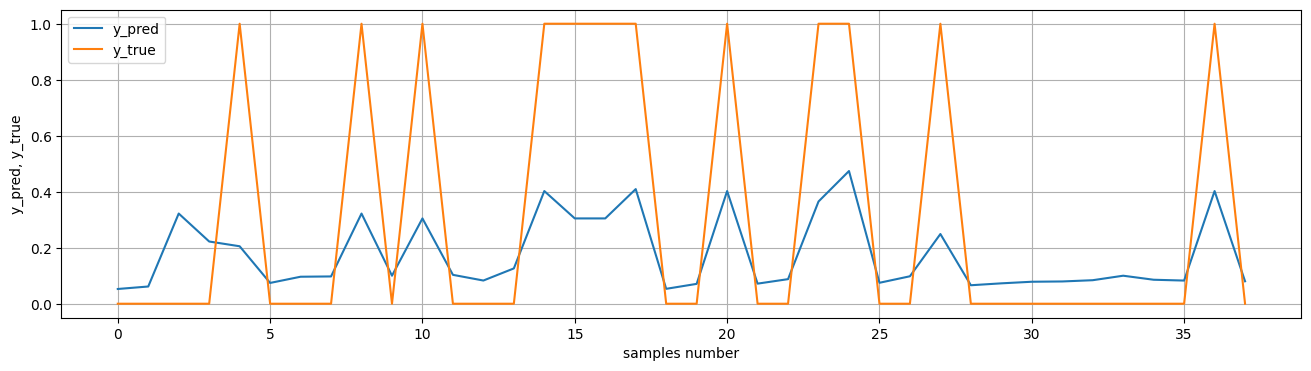

In [33]:
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y_pred, y_true')

plt.plot(preds[:, 1], label='y_pred')
plt.plot(y_test.values, label='y_true')
plt.legend()
plt.show()

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0), т.е. берем решение не сырое, а просеяное через сито условия принятия

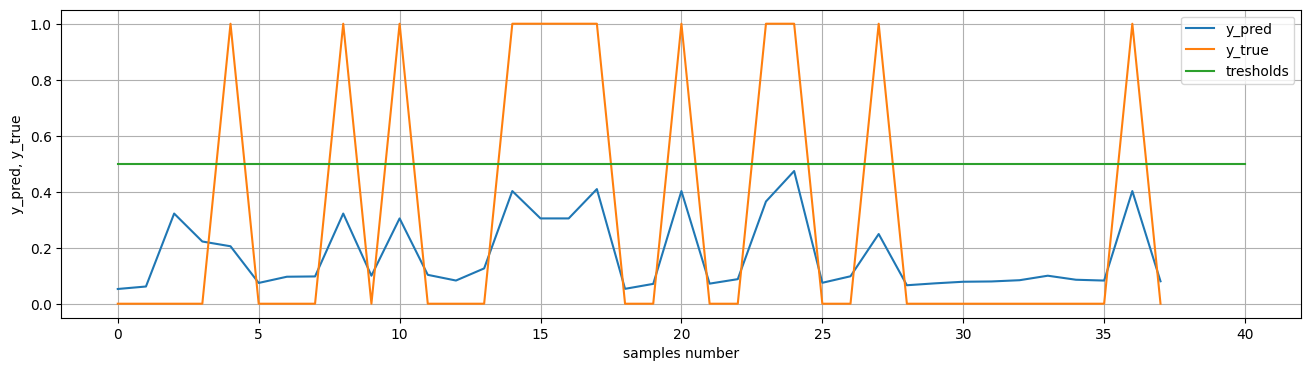

In [34]:
tresholds = 0.5

plt.figure(figsize = (16, 4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y_pred, y_true')

plt.plot(preds[:, 1], label='y_pred')
plt.plot(y_test.values, label='y_true')
plt.plot([0, 40], [tresholds, tresholds], label='tresholds')

plt.legend()
plt.show()

Вспоминаем базовые ML-метрики классификации

In [35]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, classification_report,
                             precision_recall_curve, confusion_matrix)

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds[:, 1])

In [37]:
thresholds

array([0.05263541, 0.05319808, 0.06149023, 0.06599504, 0.07087704,
       0.07174641, 0.07278446, 0.0742234 , 0.07476899, 0.07847473,
       0.07951416, 0.08014927, 0.08270076, 0.08283357, 0.08398204,
       0.08563344, 0.08776695, 0.09640315, 0.09744291, 0.09802625,
       0.1000307 , 0.10314271, 0.12612378, 0.20520248, 0.22218844,
       0.24894259, 0.30465696, 0.32204281, 0.36510129, 0.40237893,
       0.40937702, 0.47391305])

In [38]:
precision, recall

(array([0.31578947, 0.32432432, 0.33333333, 0.34285714, 0.35294118,
        0.36363636, 0.375     , 0.38709677, 0.4       , 0.4137931 ,
        0.42857143, 0.44444444, 0.46153846, 0.48      , 0.5       ,
        0.52173913, 0.54545455, 0.57142857, 0.6       , 0.63157895,
        0.66666667, 0.75      , 0.8       , 0.85714286, 0.84615385,
        0.91666667, 0.90909091, 0.875     , 1.        , 1.        ,
        1.        , 1.        , 1.        ]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.91666667,
        0.91666667, 0.83333333, 0.58333333, 0.5       , 0.41666667,
        0.16666667, 0.08333333, 0.        ]))

In [40]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.2f}, F-Score={fscore[ix]:.3f}',
      f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.21, F-Score=0.923 Precision=0.857, Recall=1.000


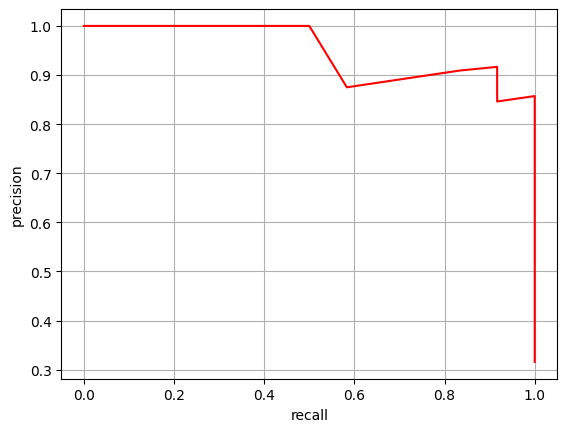

In [41]:
plt.plot(recall, precision, '-r')
plt.grid(True)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        26
           1       0.00      0.00      0.00        12

    accuracy                           0.68        38
   macro avg       0.34      0.50      0.41        38
weighted avg       0.47      0.68      0.56        38



/Users/ilaburcev/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ilaburcev/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ilaburcev/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


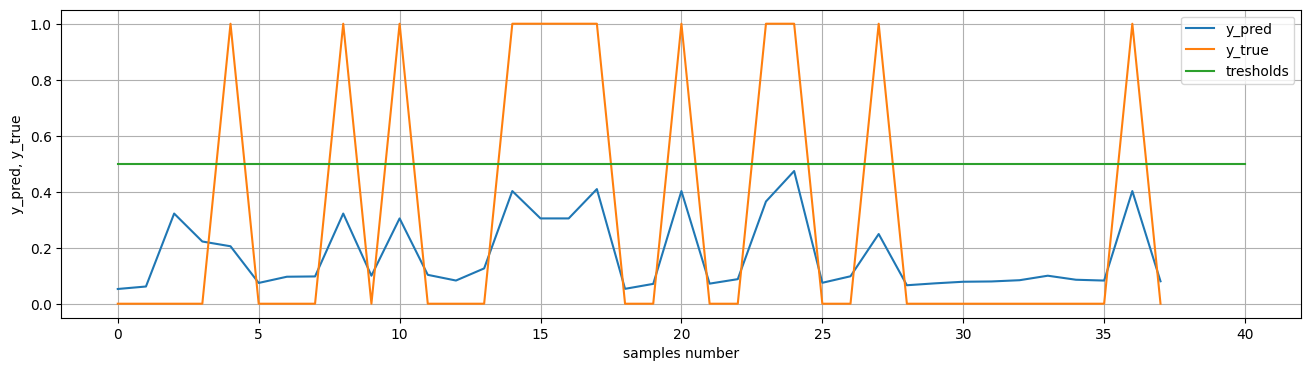

In [42]:
tresholds = .5
print(classification_report(y_test, preds[:, 1] >= tresholds))

plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y_pred, y_true')

plt.plot(preds[:, 1], label='y_pred')
plt.plot(y_test.values, label='y_true')
plt.plot([0, 40], [tresholds, tresholds], label='tresholds')

plt.legend()
plt.show()

Отрисуем матрицу ошибок для нашего примера

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
thresholds[ix]

0.2052024803614103

Confusion matrix, without normalization
[[24  2]
 [ 0 12]]


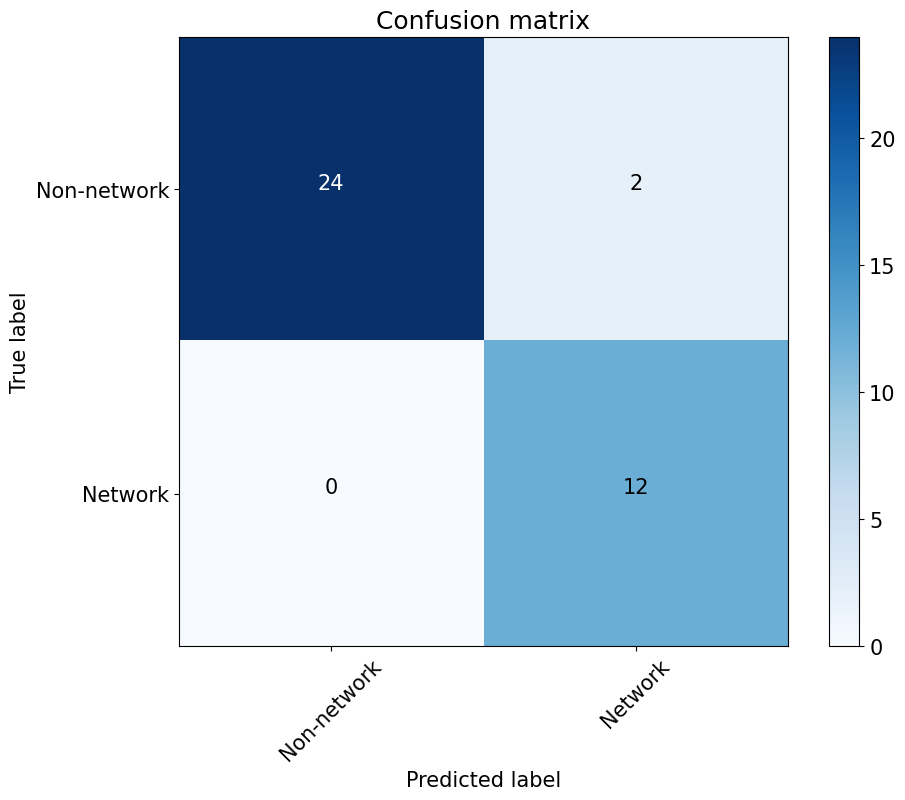

In [56]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds[:, 1] >= thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-network', 'Network'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.86      1.00      0.92        12

    accuracy                           0.95        38
   macro avg       0.93      0.96      0.94        38
weighted avg       0.95      0.95      0.95        38



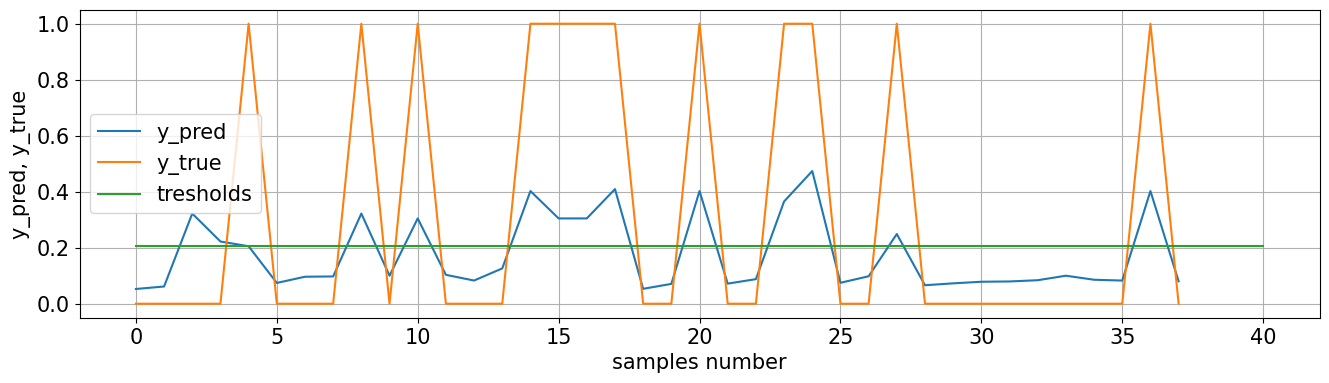

In [55]:
print(classification_report(y_test, preds[:, 1] >= thresholds[ix]))

plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y_pred, y_true')

plt.plot(preds[:, 1], label='y_pred')
plt.plot(y_test.values, label='y_true')
plt.plot([0,40], [thresholds[ix], thresholds[ix]], label='tresholds')

plt.legend()
plt.show()

доля неверно классифицированных объектов класса 1 (network) 0/12 = 0. Это меньше заявленных 0.1 (в гипотезе)
Для класса 0 ошибка 2/26 = 0.076
Общая же ошибка получилась 2 / (24+ 11 + 2 + 1) = 0.05

 выводы по этапу Ml-решения

Итак, что же мы сделали на данный момент:

1. обдумали проблему
2. сформулировали так называемую продуктовую гипотезу, в которой определили:
   - какую именно задачу мы решаем (классификация заявок по содержимому)
   - какая у нас метрика качества (доля верно классифицированных заявок)
   - условия (что ошибка не превышает 10 процентов)
3. собрали датасет и обучили модель
4. проинтерпретировали результаты моделирования и пришли к выводу, что с такой модели можно начать тестирование

Что мы еще <b>не</b> сделали:
1. НЕ спланировали эксперимент (аб-тестирование)
2. НЕ продумали интеграцию